# Dynamic Time Warping
References: 
1. https://rtavenar.github.io/blog/dtw.html?fbclid=IwAR0KXb0IF5DUXLIAMBE5Q2lTeGG7yigGyYULEhHvBhLfzXfdWBAmGogTpTg
2. https://ealizadeh.com/blog/introduction-to-dynamic-time-warping

## Import python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy, copy

## Import DTW module

In [2]:
from DTWz import generate_dtw_data, preprocess_dtw_input, compute_euclidean_distance_matrix, compute_accumulated_cost_matrix, perform_dtw

## Generate data


In [3]:
# generate fake data
xs = [[],[]]
xs[0].append(np.array([0,0,0,1,2,3,4,5,4,3,2,1,0,0,1,2,1,0,0,0]))
xs[0].append(np.array([1,1,5,7,10,4,2,1,1,1,1,3,4,1,0,0,0]))
xs[0].append(np.array([-1,2,7,10,4,2,1,1,2,1,3,4,1,1,0,1,1]))

xs[1].append(np.array([0,0,0,-1,-1,-1,-2,-1,-2,-1,-1,0,0,0,2,2,5,2,0,0]))
xs[1].append(np.array([1,1,1,-2,-1,-1,-1,-1,-2,1,0,0,1,1,0,0,0]))
xs[1].append(np.array([-1,-1,-2,-1,-2,-3,-1,-2,1,0,0,1,2,0,0,0,0]))
xs = generate_dtw_data(xs,To=50)



plot the signals

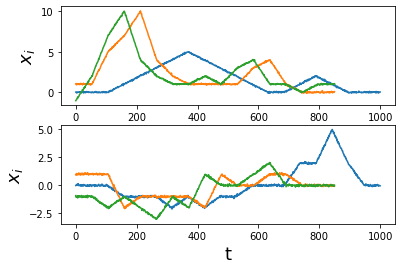

In [4]:
# visualize fake data
for n in range(len(xs)):
    plt.subplot(len(xs),1,n+1)
    for m in range(len(xs[n])):
        t = np.linspace(0,xs[n][m].shape,xs[n][m].shape[0])
        plt.plot(t,xs[n][m])
    plt.xlabel("t",fontsize=18)
    plt.ylabel("$x_i$",fontsize=18)
plt.show()

Here, we have two demonstration signals with different amplitude, different time scale, and different starting and ending points. We want to use the first (blue signal) as the template, and preprocess the second (orange signal).

## Signal Preprocessing

Note that there are four assumptions for dynamic time warping:
1. same starting and ending points
2. same amplitude/range
3. same time scale
4. same trend

Therefore, we have to preprocess them. First, we convert them into phase space, where the operation start at t = 0 and end at t = 1. Second, we  correct the offset in the starting and ending points. Third, we multiply the signal by the amplitude ratio between the template and the signal.  

In [5]:
xs = preprocess_dtw_input(xs,Td=1000)

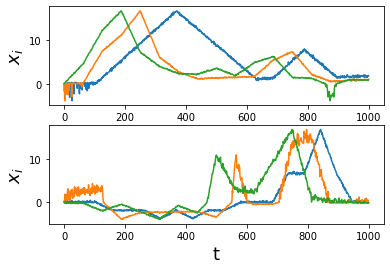

In [6]:
# visualize fake data
for n in range(len(xs)):
    plt.subplot(len(xs),1,n+1)
    for m in range(len(xs[n])):
        t = np.linspace(0,xs[n][m].shape,xs[n][m].shape[0])
        plt.plot(t,xs[n][m])
    plt.xlabel("t",fontsize=18)
    plt.ylabel("$x_i$",fontsize=18)
plt.show()

## Perform Dynamic Time Warping 
compute the distance function from the euclidian distance between each point ($x_i$ and $y_j$), return the distance matrix, and plot it.

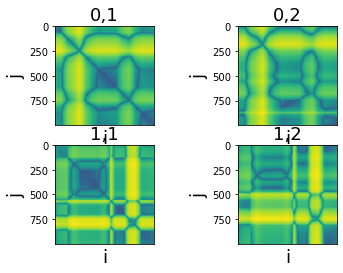

In [7]:
# visualize distance matrix
for n in range(len(xs)):
    for m in range(1,len(xs[n])):
        plt.subplot(len(xs),len(xs[0])-1,(len(xs[n])-1)*n+m)
        dist = compute_euclidean_distance_matrix(xs[n,1],xs[n,m])
        plt.imshow(dist**(1e-1))
        plt.xlabel("i",fontsize=18)
        plt.ylabel("j",fontsize=18)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        plt.title(str(n)+","+str(m),fontsize=18)
plt.show()

Then, compute accumulated cost/distance using dynamic programmin, and find the path with the shortest distance.

In [8]:
xs, r = perform_dtw(xs,k=100)
r = np.array(r)

for each signal, plot the minimal cost path on the cumulative cost matrix using the red line.

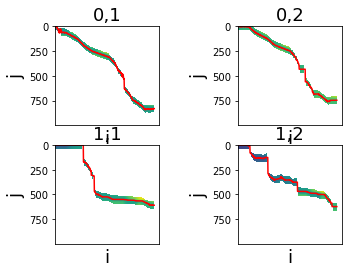

In [9]:
# visualize cummulate cost matrix
for n in range(len(xs)):
    for m in range(1,len(xs[n])):
        plt.subplot(len(xs),len(xs[0])-1,(len(xs[n])-1)*n+m)
        plt.plot(np.linspace(0,xs[n][m].shape[0],xs[n][m].shape[0]),np.argmin(r[n][m-1],0),c='red')
        plt.imshow(r[n][m-1]**(1e-1))
        plt.xlabel("i",fontsize=18)
        plt.ylabel("j",fontsize=18)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        plt.title(str(n)+","+str(m),fontsize=18)
plt.show()

Finally, plot the warped output signals

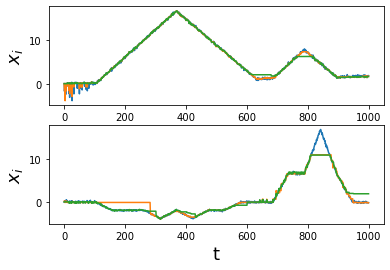

In [10]:
# visualize fake data
for n in range(len(xs)):
    plt.subplot(len(xs),1,n+1)
    for m in range(len(xs[n])):
        t = np.linspace(0,xs[n][m].shape,xs[n][m].shape[0])
        plt.plot(t,xs[n][m])
    plt.xlabel("t",fontsize=18)
    plt.ylabel("$x_i$",fontsize=18)
plt.show()